In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import datetime
from matplotlib.gridspec import GridSpec
from scipy.optimize import curve_fit
%matplotlib inline

In [2]:
##
## 1. Data ingest and data cleaning
##

df = pd.read_csv("flights.csv", low_memory=False)

In [3]:
df = df[df["MONTH"] == 11]
df.shape

(467972, 31)

In [4]:
print(df.dtypes)
print(df.head())

YEAR                     int64
MONTH                    int64
DAY                      int64
DAY_OF_WEEK              int64
AIRLINE                 object
FLIGHT_NUMBER            int64
TAIL_NUMBER             object
ORIGIN_AIRPORT          object
DESTINATION_AIRPORT     object
SCHEDULED_DEPARTURE      int64
DEPARTURE_TIME         float64
DEPARTURE_DELAY        float64
TAXI_OUT               float64
WHEELS_OFF             float64
SCHEDULED_TIME         float64
ELAPSED_TIME           float64
AIR_TIME               float64
DISTANCE                 int64
WHEELS_ON              float64
TAXI_IN                float64
SCHEDULED_ARRIVAL        int64
ARRIVAL_TIME           float64
ARRIVAL_DELAY          float64
DIVERTED                 int64
CANCELLED                int64
CANCELLATION_REASON     object
AIR_SYSTEM_DELAY       float64
SECURITY_DELAY         float64
AIRLINE_DELAY          float64
LATE_AIRCRAFT_DELAY    float64
WEATHER_DELAY          float64
dtype: object
         YEAR  MONTH  DAY

In [5]:
# import datetime
# dt = np.empty(df.shape[0], dtype = datetime.date)
# for i in range(0, df.shape[0]):
#     dt[i] = datetime.date(df.YEAR[i], df.MONTH[i], df.DAY[i])
df['DATE'] = pd.to_datetime(df[['YEAR','MONTH','DAY']])

In [6]:
df['DATE'].head()

4871877   2015-11-01
4871878   2015-11-01
4871879   2015-11-01
4871880   2015-11-01
4871881   2015-11-01
Name: DATE, dtype: datetime64[ns]

In [7]:
# format date

def format_time(data):
    if pd.isnull(data): return np.nan
    else:
        if data == 2400: data = 0
        data = "{0:04d}".format(int (data))
        return datetime.time(int (data[0:2]),int (data[2:4]))

In [8]:
# Get necessary records

df['SCHEDULED_DEPARTURE'] = df['SCHEDULED_DEPARTURE'].apply(format_time)
df['SCHEDULED_ARRIVAL'] = df['SCHEDULED_ARRIVAL'].apply(format_time)
df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].apply(format_time)
df['ARRIVAL_TIME'] = df['ARRIVAL_TIME'].apply(format_time)

df = df.loc[:,['DATE',
                       'AIRLINE',
                       'ORIGIN_AIRPORT',
                       'DESTINATION_AIRPORT',
                       'SCHEDULED_DEPARTURE',
                       'SCHEDULED_ARRIVAL',
                       'DEPARTURE_TIME',
                       'DEPARTURE_DELAY',
                       'ARRIVAL_TIME',
                       'ARRIVAL_DELAY',
                       'SCHEDULED_TIME',
                       'ELAPSED_TIME']]
df.head()

,DATE,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,DEPARTURE_TIME,DEPARTURE_DELAY,ARRIVAL_TIME,ARRIVAL_DELAY,SCHEDULED_TIME,ELAPSED_TIME
4871877,2015-11-01,NK,LAS,MSP,00:05:00,04:02:00,00:07:00,2.0,04:04:00,2.0,177.0,177.0
4871878,2015-11-01,UA,SFO,ORD,00:14:00,05:32:00,00:19:00,5.0,05:10:00,-22.0,258.0,231.0
4871879,2015-11-01,AA,LAX,MIA,00:15:00,07:11:00,00:06:00,-9.0,07:19:00,8.0,296.0,313.0
4871880,2015-11-01,UA,LAX,ORD,00:31:00,05:39:00,00:27:00,-4.0,05:18:00,-21.0,248.0,231.0
4871881,2015-11-01,UA,LAS,IAH,00:41:00,04:33:00,NaN,NaN,NaN,NaN,172.0,NaN


In [9]:
## show the portion of missing value

col1 = df.columns
col2 = df.isnull().sum()
col3 = (1 - col2 / len(df)) * 100

missing_df = pd.DataFrame({"variable":col1, "missing values":col2, "filling factor (%)":col3})
# missing_df.sort_values('filling factor (%)').reset_index(drop = True)
missing_df

,variable,missing values,filling factor (%)
DATE,DATE,0,100.000000
AIRLINE,AIRLINE,0,100.000000
ORIGIN_AIRPORT,ORIGIN_AIRPORT,0,100.000000
DESTINATION_AIRPORT,DESTINATION_AIRPORT,0,100.000000
SCHEDULED_DEPARTURE,SCHEDULED_DEPARTURE,0,100.000000
SCHEDULED_ARRIVAL,SCHEDULED_ARRIVAL,0,100.000000
DEPARTURE_TIME,DEPARTURE_TIME,4339,99.072808
DEPARTURE_DELAY,DEPARTURE_DELAY,4339,99.072808
ARRIVAL_TIME,ARRIVAL_TIME,4817,98.970665
ARRIVAL_DELAY,ARRIVAL_DELAY,5605,98.802279


In [10]:
df.dropna(inplace = True)
df.head()

,DATE,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,DEPARTURE_TIME,DEPARTURE_DELAY,ARRIVAL_TIME,ARRIVAL_DELAY,SCHEDULED_TIME,ELAPSED_TIME
4871877,2015-11-01,NK,LAS,MSP,00:05:00,04:02:00,00:07:00,2.0,04:04:00,2.0,177.0,177.0
4871878,2015-11-01,UA,SFO,ORD,00:14:00,05:32:00,00:19:00,5.0,05:10:00,-22.0,258.0,231.0
4871879,2015-11-01,AA,LAX,MIA,00:15:00,07:11:00,00:06:00,-9.0,07:19:00,8.0,296.0,313.0
4871880,2015-11-01,UA,LAX,ORD,00:31:00,05:39:00,00:27:00,-4.0,05:18:00,-21.0,248.0,231.0
4871882,2015-11-01,AS,ANC,SEA,00:45:00,04:06:00,00:42:00,-3.0,03:58:00,-8.0,201.0,196.0


In [11]:
##
## 2. Comparing Airlines
##

airlines_names = pd.read_csv('airlines.csv')
airlines_names

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways
5,OO,Skywest Airlines Inc.
6,AS,Alaska Airlines Inc.
7,NK,Spirit Air Lines
8,WN,Southwest Airlines Co.
9,DL,Delta Air Lines Inc.


In [12]:
abbr_companies = airlines_names.set_index('IATA_CODE')['AIRLINE'].to_dict()
len(abbr_companies)

14

In [13]:
# Because there was no 'US' in the November data, so it is removed
del abbr_companies['US']

In [14]:
def get_stats(group):
    return {'min': group.min(), 'max':group.max(),'count': group.count(), 'mean':group.mean()}
global_stats = df['DEPARTURE_DELAY'].groupby(df['AIRLINE']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('count')
global_stats

,count,max,mean,min
AIRLINE,,,,
VX,5345.0,288.0,5.742376,-24.0
HA,6012.0,332.0,-1.841317,-26.0
F9,7713.0,918.0,11.607935,-32.0
NK,10050.0,476.0,8.615224,-29.0
AS,13871.0,634.0,1.652368,-48.0
MQ,19331.0,931.0,6.979877,-25.0
B6,21542.0,510.0,7.085136,-31.0
EV,41644.0,993.0,7.051628,-38.0
UA,42236.0,1142.0,11.195284,-20.0


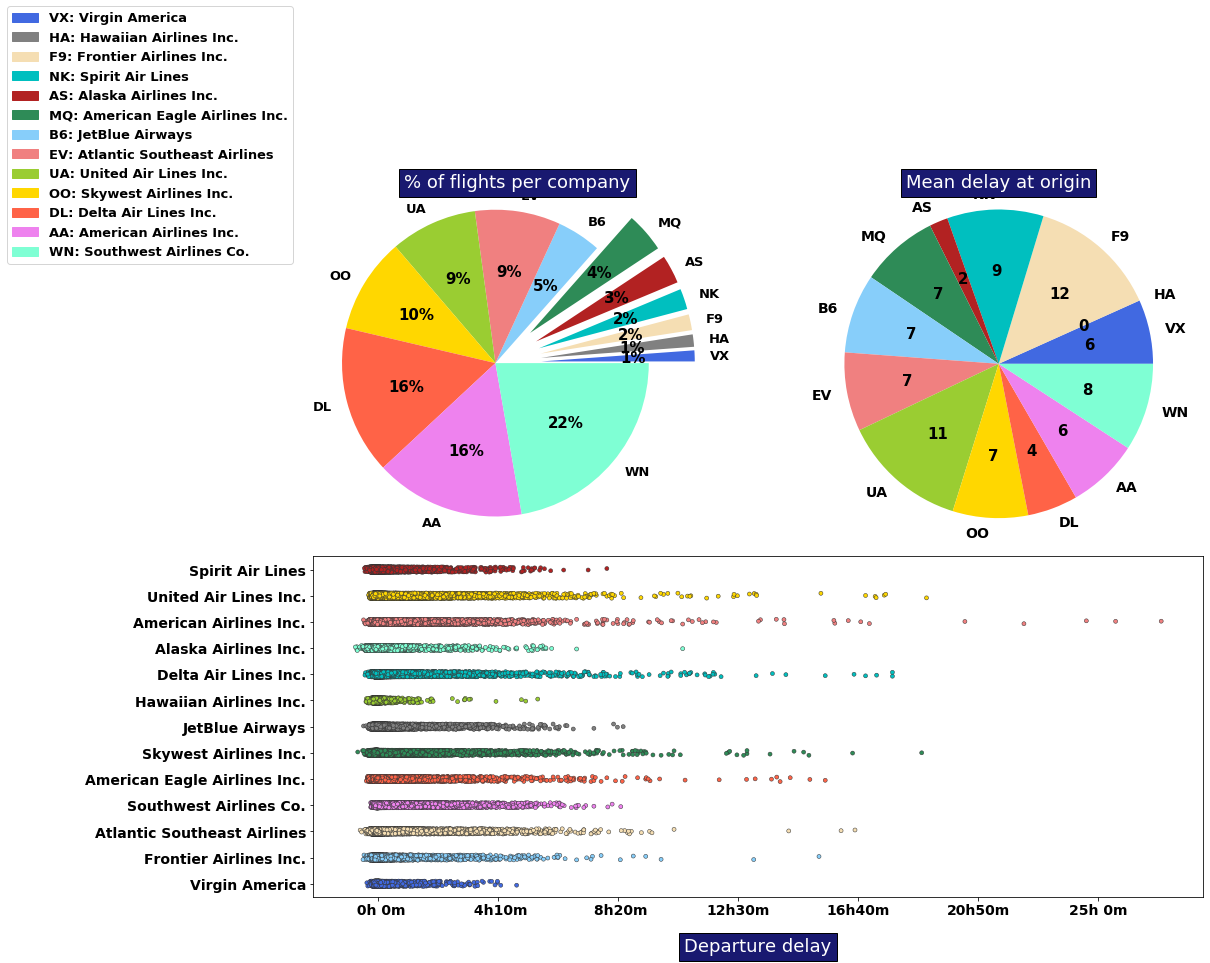

In [15]:
import matplotlib.patches as mpatches
font = { 'family': 'DejaVu Sans','weight' : 'bold', 'size' : 15}
mpl.rc('font', **font)

# extract a subset of columns and redefine the airlines labeling 
df2 = df.loc[:, ['AIRLINE', 'DEPARTURE_DELAY']]
df2['AIRLINE'] = df2['AIRLINE'].replace(abbr_companies)
#________________________________________________________________________
colors = ['royalblue', 'grey', 'wheat', 'c', 'firebrick', 'seagreen', 'lightskyblue',
          'lightcoral', 'yellowgreen', 'gold', 'tomato', 'violet', 'aquamarine']
#___________________________________
fig = plt.figure(1, figsize=(16,15))
gs=GridSpec(2,2)             
ax1=fig.add_subplot(gs[0,0]) 
ax2=fig.add_subplot(gs[0,1]) 
ax3=fig.add_subplot(gs[1,:]) 
#------------------------------
# Pie chart nº1: nb of flights
#------------------------------
labels = [s for s in  global_stats.index]
sizes  = global_stats['count'].values
explode = [0.3 if sizes[i] < 20000 else 0.0 for i in range(len(abbr_companies))]
patches, texts, autotexts = ax1.pie(sizes, explode = explode,
                                labels=labels, colors = colors,  autopct='%1.0f%%',
                                shadow=False, startangle=0)
for i in range(len(abbr_companies)): 
    texts[i].set_fontsize(13)
ax1.axis('equal')
ax1.set_title('% of flights per company', bbox={'facecolor':'midnightblue', 'pad':5},
              color = 'w',fontsize=18)
#------------------------------
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(len(abbr_companies)):
    comp_handler.append(mpatches.Patch(color=colors[i],
            label = global_stats.index[i] + ': ' + abbr_companies[global_stats.index[i]]))
ax1.legend(handles=comp_handler, bbox_to_anchor=(0.2, 0.9), 
           fontsize = 13, bbox_transform=plt.gcf().transFigure)
#----------------------------------------
# Pie chart nº2: mean delay at departure
#----------------------------------------
sizes  = global_stats['mean'].values
sizes  = [max(s,0) for s in sizes]
explode = [0.0 if sizes[i] < 20000 else 0.01 for i in range(len(abbr_companies))]
patches, texts, autotexts = ax2.pie(sizes, explode = explode, labels = labels,
                                colors = colors, shadow=False, startangle=0,
                                autopct = lambda p :  '{:.0f}'.format(p * sum(sizes) / 100))
for i in range(len(abbr_companies)): 
    texts[i].set_fontsize(14)
ax2.axis('equal')
ax2.set_title('Mean delay at origin', bbox={'facecolor':'midnightblue', 'pad':5},
              color='w', fontsize=18)
#------------------------------------------------------
# striplot with all the values reported for the delays
#___________________________________________________________________
# I redefine the colors for correspondance with the pie charts
colors = ['firebrick', 'gold', 'lightcoral', 'aquamarine', 'c', 'yellowgreen', 'grey',
          'seagreen', 'tomato', 'violet', 'wheat', 'lightskyblue', 'royalblue']
#___________________________________________________________________
ax3 = sns.stripplot(y="AIRLINE", x="DEPARTURE_DELAY", size = 4, palette = colors,
                    data=df2, linewidth = 0.5,  jitter=True)
plt.setp(ax3.get_xticklabels(), fontsize=14)
plt.setp(ax3.get_yticklabels(), fontsize=14)
ax3.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                         for x in ax3.get_xticks()])
plt.xlabel('Departure delay', fontsize=18, bbox={'facecolor':'midnightblue', 'pad':5},
           color='w', labelpad=20)
ax3.yaxis.label.set_visible(False)
#________________________
plt.tight_layout(w_pad=3)

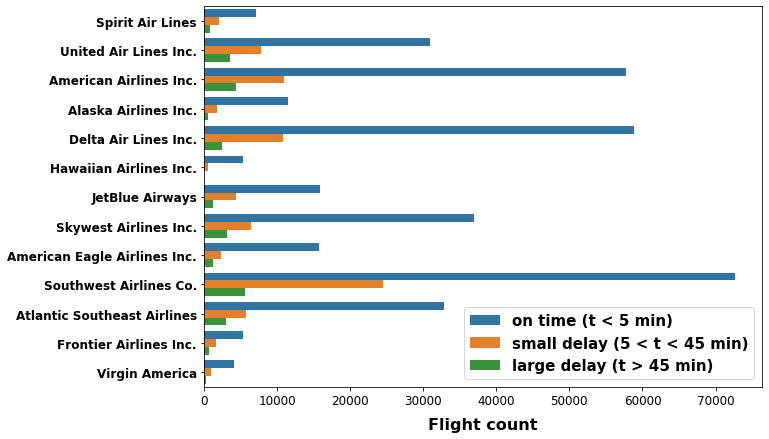

In [16]:
# Function that define how delays are grouped
delay_type = lambda x:((0,1)[x > 5],2)[x > 45]
df['DELAY_LEVEL'] = df['DEPARTURE_DELAY'].apply(delay_type)

fig = plt.figure(1, figsize=(10,7))
ax = sns.countplot(y="AIRLINE", hue='DELAY_LEVEL', data=df)

# Replace the abbreviations by the full names of the companies and set the labels
labels = [abbr_companies[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), fontsize=12, weight = 'normal', rotation = 0);
plt.setp(ax.get_yticklabels(), fontsize=12, weight = 'bold', rotation = 0);
ax.yaxis.label.set_visible(False)
plt.xlabel('Flight count', fontsize=16, weight = 'bold', labelpad=10)

# Set the legend
L = plt.legend()
L.get_texts()[0].set_text('on time (t < 5 min)')
L.get_texts()[1].set_text('small delay (5 < t < 45 min)')
L.get_texts()[2].set_text('large delay (t > 45 min)')
plt.show()

/Users/steve/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


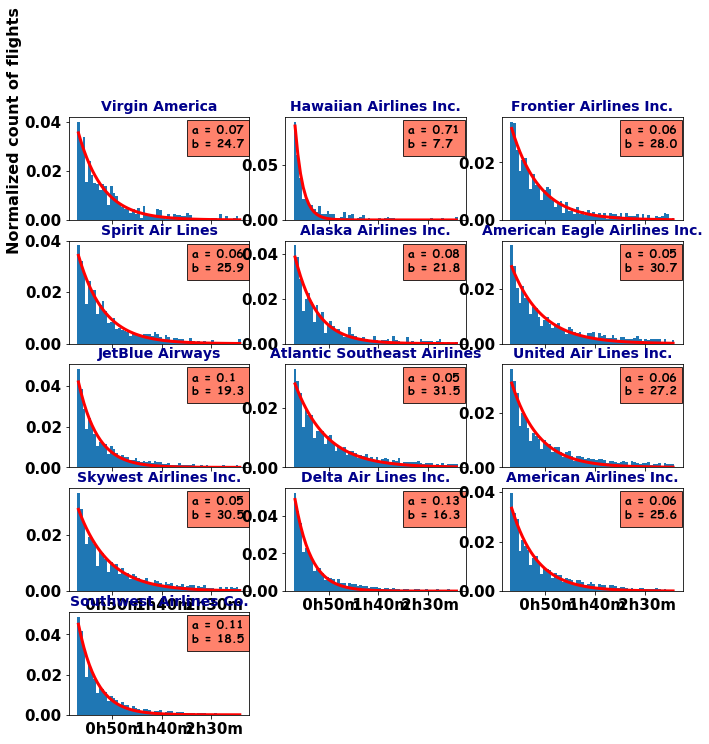

In [17]:
# Model function used to fit the histograms
def func(x, a, b):
    return a * np.exp(-x/b)
#-------------------------------------------
points = [] ; label_company = []
fig = plt.figure(1, figsize=(11,11))
i = 0
for carrier_name in [abbr_companies[x] for x in global_stats.index]:
    i += 1
    ax = fig.add_subplot(5,3,i)    
    #_________________________
    # Fit of the distribution
    n, bins, patches = plt.hist(x = df2[df2['AIRLINE']==carrier_name]['DEPARTURE_DELAY'],
                                range = (15,180), density=True, bins= 60)
    bin_centers = bins[:-1] + 0.5 * (bins[1:] - bins[:-1])    
    popt, pcov = curve_fit(func, bin_centers, n, p0 = [1, 2])
    #___________________________
    # bookeeping of the results
    points.append(popt)
    label_company.append(carrier_name)
    #______________________
    # draw the fit curve
    plt.plot(bin_centers, func(bin_centers, *popt), 'r-', linewidth=3)    
    #_____________________________________
    # define tick labels for each subplot
    if i < 10:
        ax.set_xticklabels(['' for x in ax.get_xticks()])
    else:
        ax.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                            for x in ax.get_xticks()])
    #______________
    # subplot title
    plt.title(carrier_name, fontsize = 14, fontweight = 'bold', color = 'darkblue')
    #____________
    # axes labels 
    if i == 4:
        ax.text(-0.3,0.9,'Normalized count of flights', fontsize=16, rotation=90,
            color='k', horizontalalignment='center', transform = ax.transAxes)
    if i == 14:
        ax.text( 0.5, -0.5 ,'Delay at origin', fontsize=16, rotation=0,
            color='k', horizontalalignment='center', transform = ax.transAxes)
        
# Legend: values of the a and b coefficients
    ax.text(0.68, 0.7, 'a = {}\nb = {}'.format(round(popt[0],2), round(popt[1],1)),
            style='italic', transform=ax.transAxes, fontsize = 12, family='fantasy',
            bbox={'facecolor':'tomato', 'alpha':0.8, 'pad':5})
    
plt.tight_layout()

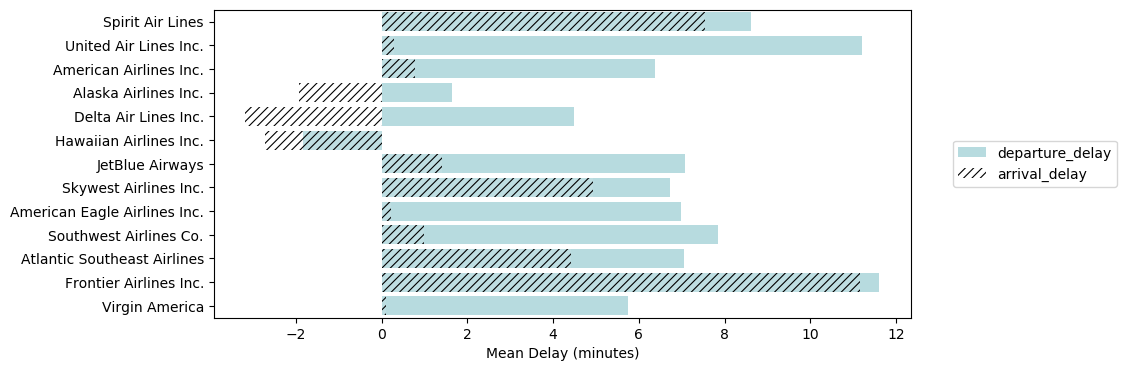

In [18]:
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['hatch.linewidth'] = 0.8

fig = plt.figure(1, figsize = (9, 4))
ax = sns.barplot(x = 'DEPARTURE_DELAY', y = 'AIRLINE', data = df, color = 'powderblue', ci = None, label = 'departure_delay')
ax = sns.barplot(x = 'ARRIVAL_DELAY', y = 'AIRLINE', data = df, color = 'white', hatch = '////', alpha = 0.1, ci = None, label = 'arrival_delay')
labels = [abbr_companies[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
ax.yaxis.label.set_visible(False)
plt.xlabel('Mean Delay (minutes)')
plt.legend(loc = 'center left', bbox_to_anchor = (1.05, 0.5))
plt.show()

In [19]:
##
## Relation between the origin airport and delays
##

len(df['ORIGIN_AIRPORT'].unique())


305

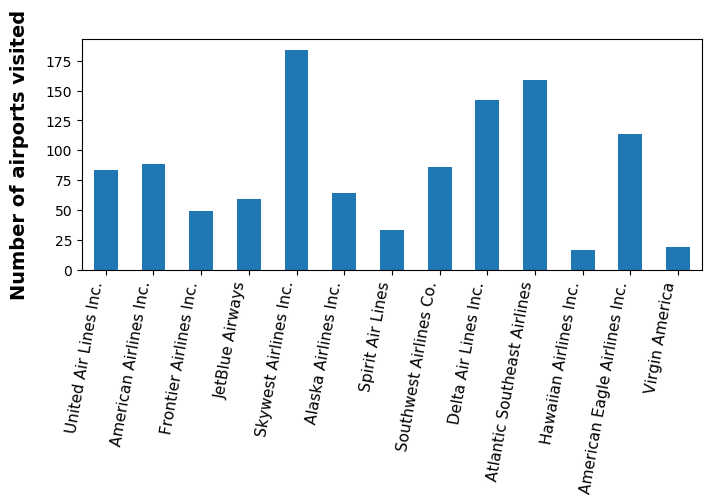

In [20]:
origin_nb = dict()
for carrier in abbr_companies.keys():
    liste_origin_airport = df[df['AIRLINE'] == carrier]['ORIGIN_AIRPORT'].unique()
    origin_nb[carrier] = len(liste_origin_airport)
test_df = pd.DataFrame.from_dict(origin_nb, orient='index')
test_df.rename(columns = {0:'count'}, inplace = True)
ax = test_df.plot(kind='bar', figsize = (8,3))
labels = [abbr_companies[item.get_text()] for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
plt.ylabel('Number of airports visited', fontsize=14, weight = 'bold', labelpad=12)
plt.setp(ax.get_xticklabels(), fontsize=11, ha = 'right', rotation = 80)
ax.legend().set_visible(False)
plt.show()

In [2]:
##
## part6 Predict Flight Delays
## 
from sklearn.metrics import confusion_matrix

In [3]:
df_clean = pd.read_csv("filghts_data_clean.csv", low_memory=False)

In [4]:
df_clean = df_clean.drop(["ARRIVAL_TIME","ARRIVAL_DELAY","SCHEDULED_ARRIVAL","SCHEDULED_TIME","ELAPSED_TIME"], axis = 1)
df_clean.head()


,DATE,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY
0,11/1/15,NK,LAS,MSP,0,0,2
1,11/1/15,UA,SFO,ORD,0,0,5
2,11/1/15,AA,LAX,MIA,0,0,-9
3,11/1/15,UA,LAX,ORD,0,0,-4
4,11/1/15,AS,ANC,SEA,0,0,-3


In [5]:
df_clean["DEPARTURE_DELAY"] = df_clean["DEPARTURE_DELAY"].map(lambda x: 2 if x > 60 else (1 if x > 20 else 0))
df_clean.head()

,DATE,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY
0,11/1/15,NK,LAS,MSP,0,0,0
1,11/1/15,UA,SFO,ORD,0,0,0
2,11/1/15,AA,LAX,MIA,0,0,0
3,11/1/15,UA,LAX,ORD,0,0,0
4,11/1/15,AS,ANC,SEA,0,0,0


In [6]:
df_clean = df_clean.drop("DATE", axis = 1)
df_clean = pd.get_dummies(df_clean, columns=['AIRLINE', 'ORIGIN_AIRPORT','DESTINATION_AIRPORT'])
df_clean.head()

,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,AIRLINE_AA,AIRLINE_AS,AIRLINE_B6,AIRLINE_DL,AIRLINE_EV,AIRLINE_F9,AIRLINE_HA,...,DESTINATION_AIRPORT_TXK,DESTINATION_AIRPORT_TYR,DESTINATION_AIRPORT_TYS,DESTINATION_AIRPORT_UST,DESTINATION_AIRPORT_VLD,DESTINATION_AIRPORT_VPS,DESTINATION_AIRPORT_WRG,DESTINATION_AIRPORT_XNA,DESTINATION_AIRPORT_YAK,DESTINATION_AIRPORT_YUM
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(df_clean.drop('DEPARTURE_DELAY', axis=1), df_clean['DEPARTURE_DELAY'], test_size=0.2, random_state=42)

In [8]:
from sklearn.linear_model import LogisticRegression
model1 = LogisticRegression()
model1.fit(train_x, train_y)
predicted1 = model1.predict(test_x)
model1.score(test_x, test_y)

/Users/steve/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/steve/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.9021022125137876

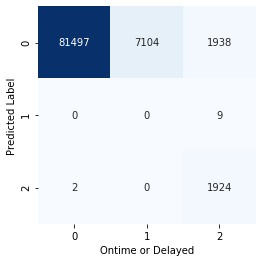

In [9]:
mat = confusion_matrix(test_y, predicted1)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap="Blues")
plt.xlabel('Ontime or Delayed')
plt.ylabel('Predicted Label');

In [10]:
from sklearn.naive_bayes import MultinomialNB
model2 = MultinomialNB()
model2.fit(train_x, train_y);
predicted2 = model2.predict(test_x)
model2.score(test_x, test_y)

0.8813071782338819

Text(91.68, 0.5, 'Predicted Label')

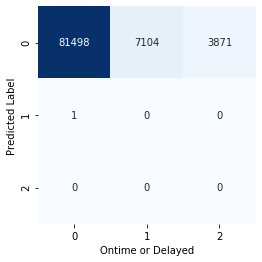

In [11]:
mat = confusion_matrix(test_y, predicted2)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap="Blues")
plt.xlabel('Ontime or Delayed')
plt.ylabel('Predicted Label')

In [12]:
from sklearn.svm import SVC # "Support vector classifier"
model3 = SVC(kernel='linear', C=1E8, max_iter = 100) #set max iteration time to end program 
model3.fit(train_x, train_y)
predicted3 = model3.predict(test_x)
model3.score(test_x, test_y)


/Users/steve/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


0.7329952202781322

Text(91.68, 0.5, 'Predicted Label')

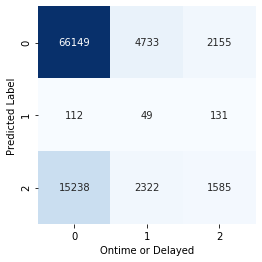

In [13]:
mat = confusion_matrix(test_y, predicted3)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap="Blues")
plt.xlabel('Ontime or Delayed')
plt.ylabel('Predicted Label')

In [14]:
from sklearn.neighbors import KNeighborsClassifier
model4 = KNeighborsClassifier(leaf_size = 15, n_jobs = -1) # imporve the efficiency: set small leaf_size and use all processors
model4.fit(train_x, train_y);
predicted4 = model4.predict(test_x)
model4.score(test_x, test_y)

0.901842680104678

Text(91.68, 0.5, 'Predicted Label')

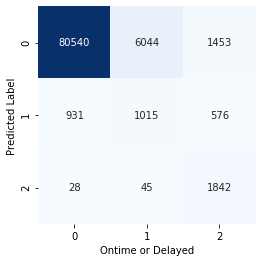

In [15]:
mat = confusion_matrix(test_y, predicted4)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap="Blues")
plt.xlabel('Ontime or Delayed')
plt.ylabel('Predicted Label')

In [16]:
from sklearn.ensemble import RandomForestClassifier
model5 = RandomForestClassifier(random_state=13)
model5.fit(train_x, train_y)
predicted5 = model5.predict(test_x)
model5.score(test_x, test_y)

/Users/steve/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9135540800657482

Text(91.68, 0.5, 'Predicted Label')

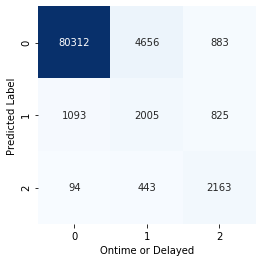

In [17]:
mat = confusion_matrix(test_y, predicted5)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap="Blues")
plt.xlabel('Ontime or Delayed')
plt.ylabel('Predicted Label')